In [1]:
%load_ext Cython
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower', interpolation='nearest')

In [2]:
import os
os.environ['CC'] = 'gcc-6'

In [3]:
%%cython -a

cimport cython

ctypedef double real_t
cdef struct real2_t:
    real_t x, y, z
cdef struct particle_t:
    real_t x, y, vx, vy, vz

cdef class grid_t:
    """Grid extension type.
    This is inherited by the Grid class (see grid.py)."""
    # TODO: Either define *all* attributes of the grid class or only those that
    # are actually needed
    cdef public int lbx, lby

@cython.boundscheck(False)
@cython.wraparound(False)
def deposit_inline(particle_t[:] particles, real_t[:, :] rho, real2_t[:,:] J, grid_t grid, real_t S):

    cdef int Np = particles.shape[0]
    cdef int ip    
    cdef real2_t offset

    offset.x = <real_t> grid.lbx - 0.5
    offset.y = <real_t> grid.lby - 0.5

    # Density deposition
    for ip in range(Np):
        deposit_particle(particles[ip], rho, J, grid, S, offset)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline void deposit_particle(particle_t particle, real_t[:,:] rho, real2_t[:,:] J,
                                  grid_t grid, real_t S, real2_t offset) nogil:

    cdef int ix, iy
    cdef real_t tx, ty, dx, dy, x, y

    x = particle.x + offset.x
    y = particle.y + offset.y

    ix = <int> x
    iy = <int> y

    dx = x - <real_t> ix
    dy = y - <real_t> iy

    tx = 1.0 - dx
    ty = 1.0 - dy

    rho[iy  , ix  ] += ty*tx
    rho[iy  , ix+1] += ty*dx
    rho[iy+1, ix  ] += dy*tx
    rho[iy+1, ix+1] += dy*dx

    J[iy  , ix  ].x += ty*tx*(particle.vx + S*particle.y)
    J[iy  , ix+1].x += ty*dx*(particle.vx + S*particle.y)
    J[iy+1, ix  ].x += dy*tx*(particle.vx + S*particle.y)
    J[iy+1, ix+1].x += dy*dx*(particle.vx + S*particle.y)

    J[iy  , ix  ].y += ty*tx*particle.vy
    J[iy  , ix+1].y += ty*dx*particle.vy
    J[iy+1, ix  ].y += dy*tx*particle.vy
    J[iy+1, ix+1].y += dy*dx*particle.vy

    J[iy  , ix  ].z += ty*tx*particle.vz
    J[iy  , ix+1].z += ty*dx*particle.vz
    J[iy+1, ix  ].z += dy*tx*particle.vz
    J[iy+1, ix+1].z += dy*dx*particle.vz

@cython.boundscheck(False)
@cython.wraparound(False)
def deposit(particle_t[:] particles, real_t[:, :] rho, real2_t[:,:] J, grid_t grid, real_t S):

    cdef int Np = particles.shape[0]
    cdef int ip
    cdef int ix, iy
    cdef real_t tx, ty, dx, dy, x, y
    cdef real2_t offset

    offset.x = <real_t> grid.lbx - 0.5
    offset.y = <real_t> grid.lby - 0.5

    # Density deposition
    for ip in range(Np):

        x = particles[ip].x + offset.x
        y = particles[ip].y + offset.y

        ix = <int> x
        iy = <int> y

        dx = x - <real_t> ix
        dy = y - <real_t> iy

        tx = 1.0 - dx
        ty = 1.0 - dy

        rho[iy  , ix  ] += ty*tx
        rho[iy  , ix+1] += ty*dx
        rho[iy+1, ix  ] += dy*tx
        rho[iy+1, ix+1] += dy*dx

        J[iy  , ix  ].x += ty*tx*(particles[ip].vx + S*particles[ip].y)
        J[iy  , ix+1].x += ty*dx*(particles[ip].vx + S*particles[ip].y)
        J[iy+1, ix  ].x += dy*tx*(particles[ip].vx + S*particles[ip].y)
        J[iy+1, ix+1].x += dy*dx*(particles[ip].vx + S*particles[ip].y)

        J[iy  , ix  ].y += ty*tx*particles[ip].vy
        J[iy  , ix+1].y += ty*dx*particles[ip].vy
        J[iy+1, ix  ].y += dy*tx*particles[ip].vy
        J[iy+1, ix+1].y += dy*dx*particles[ip].vy

        J[iy  , ix  ].z += ty*tx*particles[ip].vz
        J[iy  , ix+1].z += ty*dx*particles[ip].vz
        J[iy+1, ix  ].z += dy*tx*particles[ip].vz
        J[iy+1, ix+1].z += dy*dx*particles[ip].vz

In [4]:
class Grid(grid_t):
    def __init__(self, nx, ny, lbx=1, lby=1):
        self.nx = nx
        self.ny = ny
        self.lbx = lbx
        self.lby = lby
        self.ubx = lbx + nx
        self.uby = lby + ny

grid = Grid(256, 256, lbx=1, lby=1)

In [5]:
import numpy as np
Float = np.double
Float2 = [('x', Float), ('y', Float), ('z', Float)]

Particle = np.dtype(
    [('x', Float), ('y', Float), ('vx', Float), ('vy', Float),
    ('vz', Float)], align=True)

npc = 256
N = grid.nx*grid.ny*npc
particles = np.empty(N, dtype=Particle)
shape = grid.ny + 2*grid.lby, grid.nx + 2*grid.lbx

In [6]:
particles['x'] = np.random.uniform(size=N)*grid.nx
particles['y'] = np.random.uniform(size=N)*grid.ny

In [7]:
%%timeit -n 10 rho = np.zeros(shape, dtype=Float); J = np.zeros(shape, dtype=Float2);
deposit_inline(particles, rho, J, grid, 0.0)

10 loops, best of 3: 624 ms per loop


In [8]:
%%timeit -n 10 rho = np.zeros(shape, dtype=Float); J = np.zeros(shape, dtype=Float2);
deposit(particles, rho, J, grid, 0.0)

10 loops, best of 3: 616 ms per loop


In [9]:
sqrt_npc = int(np.sqrt(npc))
assert sqrt_npc**2 == npc
dx = dy = 1/sqrt_npc
x, y = np.meshgrid(
    (np.arange(grid.nx*sqrt_npc) + 0.5)/sqrt_npc,
    (np.arange(grid.ny*sqrt_npc) + 0.5)/sqrt_npc)

particles['x'] = x.flatten()
particles['y'] = y.flatten()

In [10]:
%%timeit -n 10 rho = np.zeros(shape, dtype=Float); J = np.zeros(shape, dtype=Float2);
deposit_inline(particles, rho, J, grid, 0.0)

10 loops, best of 3: 343 ms per loop


In [11]:
%%timeit -n 10 rho = np.zeros(shape, dtype=Float); J = np.zeros(shape, dtype=Float2);
deposit(particles, rho, J, grid, 0.0)

10 loops, best of 3: 337 ms per loop


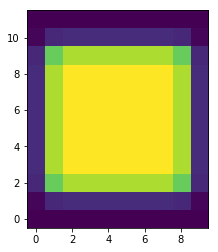

In [13]:
grid = Grid(8, 8, lbx=1, lby=2)

npc = 256
N = grid.nx*grid.ny*npc
particles = np.empty(N, dtype=Particle)
shape = grid.ny + 2*grid.lby, grid.nx + 2*grid.lbx

sqrt_npc = int(np.sqrt(npc))
assert sqrt_npc**2 == npc
dx = dy = 1/sqrt_npc
x, y = np.meshgrid(
    (np.arange(grid.nx*sqrt_npc) + 0.5)/sqrt_npc,
    (np.arange(grid.ny*sqrt_npc) + 0.5)/sqrt_npc)

particles['x'] = x.flatten()
particles['y'] = y.flatten()

rho = np.zeros(shape, dtype=Float)
J = np.zeros(shape, dtype=Float2)
deposit_inline(particles, rho, J, grid, 0.0)

boundary = False
if boundary:
    rho[:, grid.lbx         :grid.lbx+grid.lbx] += rho[:,  grid.ubx:]
    rho[:, grid.ubx-grid.lbx:grid.ubx         ] += rho[:, :grid.lbx ]

    rho[grid.lby         :grid.lby+grid.lby, :] += rho[ grid.uby:, :]
    rho[grid.uby-grid.lby:grid.uby         , :] += rho[:grid.lby , :]

    assert int(rho[grid.lby:grid.uby, grid.lbx:grid.ubx].sum()) == N
else:
    assert int(rho.sum()) == N

plt.imshow(rho);